## DISASTER TWEET CLASSIFICATION: Real vs Metaphorical Disaster Detection

###  Binary classification of tweets into real disasters (1) vs non-disasters (0)

### Step 1: Environment Setup & Dependencies Installation

In [22]:
# ===============================================================
# Step 1: Environment Setup & Dependencies Installation
# ===============================================================
"""
Install required libraries for:
- Transformers (Hugging Face): Pre-trained language models
- Datasets: Efficient data handling
- Accelerate: Optimized training
- scikit-learn: ML metrics and preprocessing
"""

!pip install transformers datasets accelerate -q
!pip install scikit-learn pandas numpy matplotlib seaborn -q

print("✓ All dependencies installed successfully!")

✓ All dependencies installed successfully!


### Step 2: Import Libraries

In [23]:
# =================================================================================
# Step 2: Import Libraries
# =================================================================================
"""
Import all necessary libraries for data processing, modeling, and evaluation
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


### Step 3: Mount & Load Data


In [7]:
# =================================================================================
# STEP 3: Mount Google Drive & Load Data
# =================================================================================
"""
Mount Google Drive to access the dataset
Load train.csv with disaster tweet data
"""

from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
DATA_PATH = '/content/drive/MyDrive/tweet_classification/train.csv'

df = pd.read_csv(DATA_PATH)
print("✓ Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Dataset loaded successfully!

Dataset shape: (7613, 2)

First few rows:
                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1


###  Step 4: Exploratory Data Analysis (EDA)


EXPLORATORY DATA ANALYSIS

1. Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB
None

2. Missing Values:
text      0
target    0
dtype: int64

3. Class Distribution:
target
0    4342
1    3271
Name: count, dtype: int64

Class Balance:
Non-Disaster (0): 57.03%
Disaster (1): 42.97%

4. Duplicate tweets: 110

5. Text Statistics:
       text_length                                                          \
             count        mean        std   min   25%    50%    75%    max   
target                                                                       
0           4342.0   95.706817  35.885924   7.0  68.0  101.0  130.0  157.0   
1           3271.0  108.113421  29.309854  14.0  88.0  115.0  136.0  151.0   

       word_cou

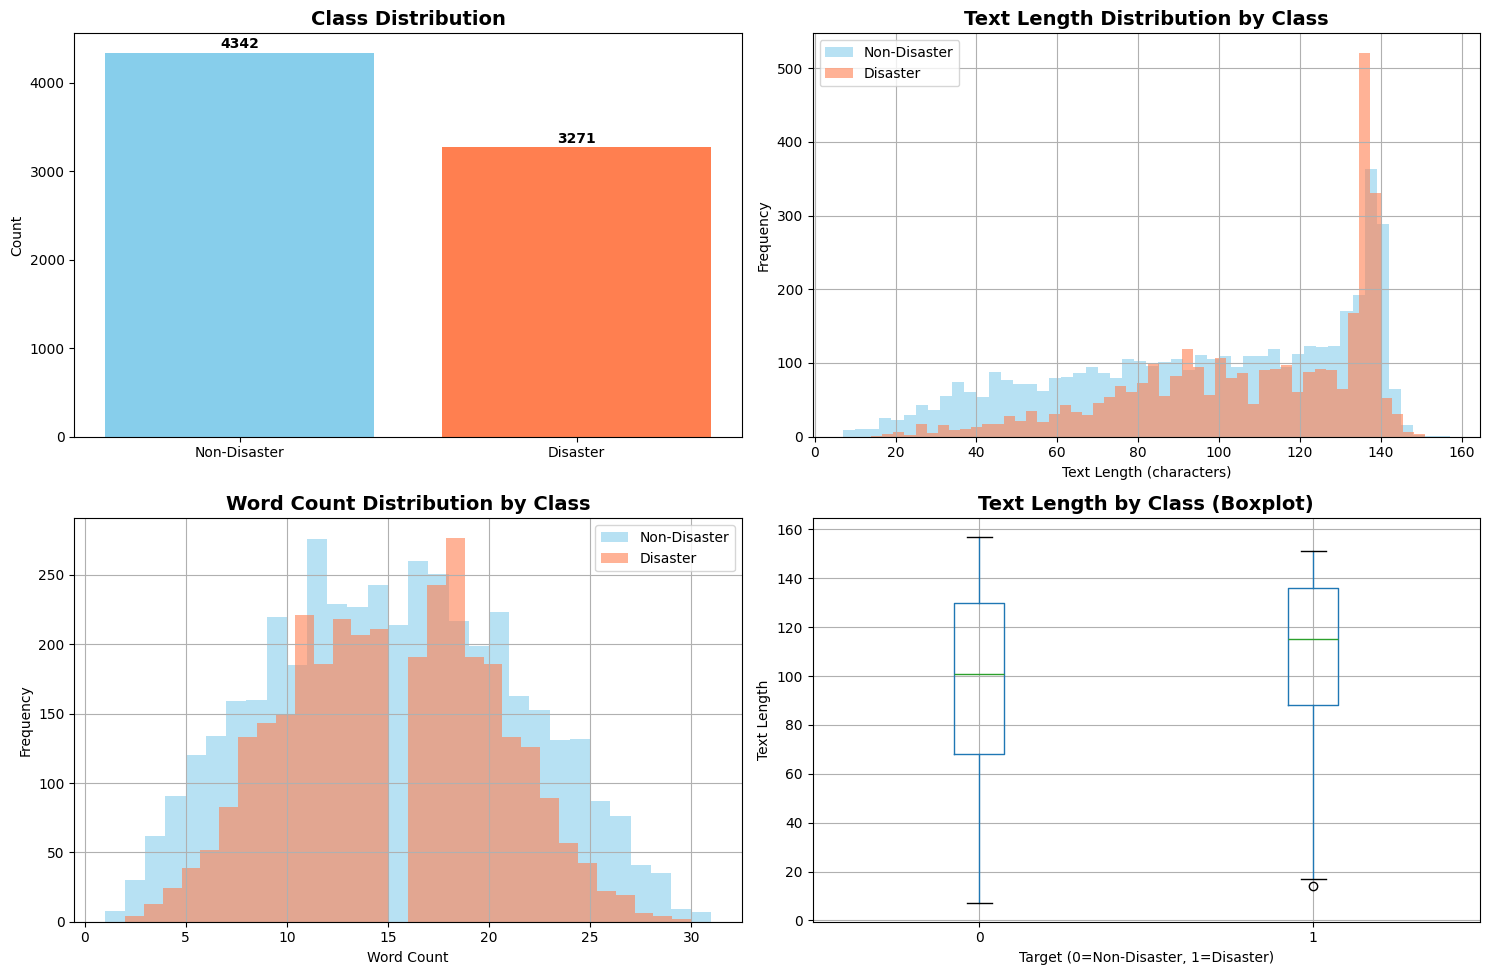


6. Sample Tweets:

--- DISASTER TWEETS (target=1) ---
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
2. Forest fire near La Ronge Sask. Canada
3. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

--- NON-DISASTER TWEETS (target=0) ---
1. What's up man?
2. I love fruits
3. Summer is lovely


In [8]:
# =================================================================================
# Step 4: Exploratory Data Analysis (EDA)
# =================================================================================
"""
Comprehensive analysis of the dataset:
- Check for missing values
- Analyze class distribution
- Examine text characteristics
- Identify potential issues
"""

print("="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Basic information
print("\n1. Dataset Info:")
print(df.info())

print("\n2. Missing Values:")
print(df.isnull().sum())

print("\n3. Class Distribution:")
class_dist = df['target'].value_counts()
print(class_dist)
print(f"\nClass Balance:")
print(f"Non-Disaster (0): {class_dist[0]/len(df)*100:.2f}%")
print(f"Disaster (1): {class_dist[1]/len(df)*100:.2f}%")

# Check for duplicates
print(f"\n4. Duplicate tweets: {df.duplicated(subset=['text']).sum()}")

# Text length analysis
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("\n5. Text Statistics:")
print(df.groupby('target')[['text_length', 'word_count']].describe())

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Class distribution
axes[0, 0].bar(['Non-Disaster', 'Disaster'], class_dist.values, color=['skyblue', 'coral'])
axes[0, 0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(class_dist.values):
    axes[0, 0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Text length distribution by class
df[df['target']==0]['text_length'].hist(bins=50, alpha=0.6, label='Non-Disaster', ax=axes[0, 1], color='skyblue')
df[df['target']==1]['text_length'].hist(bins=50, alpha=0.6, label='Disaster', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Text Length Distribution by Class', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Text Length (characters)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Word count distribution
df[df['target']==0]['word_count'].hist(bins=30, alpha=0.6, label='Non-Disaster', ax=axes[1, 0], color='skyblue')
df[df['target']==1]['word_count'].hist(bins=30, alpha=0.6, label='Disaster', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Word Count Distribution by Class', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Box plot for text length
df.boxplot(column='text_length', by='target', ax=axes[1, 1])
axes[1, 1].set_title('Text Length by Class (Boxplot)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Target (0=Non-Disaster, 1=Disaster)')
axes[1, 1].set_ylabel('Text Length')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Sample tweets from each class
print("\n6. Sample Tweets:")
print("\n--- DISASTER TWEETS (target=1) ---")
for i, tweet in enumerate(df[df['target']==1]['text'].head(3).values, 1):
    print(f"{i}. {tweet}")

print("\n--- NON-DISASTER TWEETS (target=0) ---")
for i, tweet in enumerate(df[df['target']==0]['text'].head(3).values, 1):
    print(f"{i}. {tweet}")


### Step 5: Data Preprocessing

In [9]:
# =================================================================================
# Step 5: Data Preprocessing
# =================================================================================
"""
Minimal preprocessing for transformer models:
- Remove duplicates if any
- Handle missing values
- Basic text cleaning
- Create train/validation split
"""

print("="*80)
print("DATA PREPROCESSING")
print("="*80)

# Remove duplicates
initial_size = len(df)
df = df.drop_duplicates(subset=['text'], keep='first')
print(f"✓ Removed {initial_size - len(df)} duplicate tweets")

# Handle missing values
df = df.dropna(subset=['text', 'target'])
print(f"✓ Dataset size after cleaning: {len(df)}")

# Prepare data for modeling
X = df['text'].values
y = df['target'].values

# Stratified train-validation split (80-20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"\n✓ Train set size: {len(X_train)}")
print(f"✓ Validation set size: {len(X_val)}")
print(f"\nTrain class distribution:")
print(f"  Non-Disaster: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Disaster: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")


DATA PREPROCESSING
✓ Removed 110 duplicate tweets
✓ Dataset size after cleaning: 7503

✓ Train set size: 6002
✓ Validation set size: 1501

Train class distribution:
  Non-Disaster: 3444 (57.38%)
  Disaster: 2558 (42.62%)


### Step 6: Baseline Model - Logistic Regression with TF-IDF

BASELINE MODEL: LOGISTIC REGRESSION + TF-IDF

 Vectorizing text with TF-IDF...
✓ TF-IDF shape: (6002, 5000)

 Training Logistic Regression...

BASELINE MODEL RESULTS

Training Set Performance:
  Accuracy:  0.8744
  F1-Score:  0.8499

Validation Set Performance:
  Accuracy:  0.7848
  F1-Score:  0.7455
  Precision: 0.7520
  Recall:    0.7391

Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.81      0.82      0.81       861
    Disaster       0.75      0.74      0.75       640

    accuracy                           0.78      1501
   macro avg       0.78      0.78      0.78      1501
weighted avg       0.78      0.78      0.78      1501



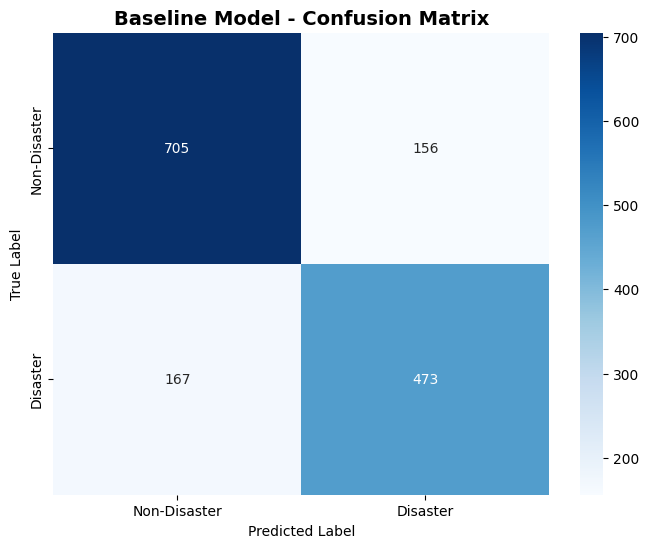

In [10]:
# =================================================================================
# Step 6: Baseline Model - Logistic Regression with TF-IDF
# =================================================================================
"""
Quick baseline model to establish performance floor:
- TF-IDF vectorization
- Logistic Regression classifier
- Provides fast benchmark for comparison
"""

print("="*80)
print("BASELINE MODEL: LOGISTIC REGRESSION + TF-IDF")
print("="*80)

# TF-IDF Vectorization
print("\n Vectorizing text with TF-IDF...")
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # unigrams and bigrams
    min_df=2,
    max_df=0.9
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print(f"✓ TF-IDF shape: {X_train_tfidf.shape}")

# Train Logistic Regression
print("\n Training Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED,
    class_weight='balanced'  # Handle class imbalance
)
lr_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred_train = lr_model.predict(X_train_tfidf)
y_pred_val = lr_model.predict(X_val_tfidf)

# Evaluation
print("\n" + "="*80)
print("BASELINE MODEL RESULTS")
print("="*80)

print("\nTraining Set Performance:")
print(f"  Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"  F1-Score:  {f1_score(y_train, y_pred_train):.4f}")

print("\nValidation Set Performance:")
print(f"  Accuracy:  {accuracy_score(y_val, y_pred_val):.4f}")
print(f"  F1-Score:  {f1_score(y_val, y_pred_val):.4f}")
print(f"  Precision: {precision_score(y_val, y_pred_val):.4f}")
print(f"  Recall:    {recall_score(y_val, y_pred_val):.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_val, target_names=['Non-Disaster', 'Disaster']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Disaster', 'Disaster'],
            yticklabels=['Non-Disaster', 'Disaster'])
plt.title('Baseline Model - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Step 7: Prepare Data for DistilBERT





In [11]:
# =================================================================================
# Step 7: Prepare Data for DistilBERT
# =================================================================================
"""
Convert data to Hugging Face Dataset format:
- Tokenize text with DistilBERT tokenizer
- Create Dataset objects for efficient loading
- Set up for transformer training
"""

print("="*80)
print("PREPARING DATA FOR DISTILBERT")
print("="*80)

# Initialize tokenizer
MODEL_NAME = "distilbert-base-uncased"
print(f"\n Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenization function
def tokenize_function(examples):
    """Tokenize text with truncation and padding"""
    return tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=128  # Most tweets are short
    )

# Create Hugging Face datasets
train_dataset = Dataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train.tolist()
})

val_dataset = Dataset.from_dict({
    'text': X_val.tolist(),
    'label': y_val.tolist()
})

print(f"✓ Train dataset: {len(train_dataset)} samples")
print(f"✓ Validation dataset: {len(val_dataset)} samples")

# Tokenize datasets
print("\n Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✓ Tokenization complete!")


PREPARING DATA FOR DISTILBERT

 Loading tokenizer: distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✓ Train dataset: 6002 samples
✓ Validation dataset: 1501 samples

 Tokenizing datasets...


Map:   0%|          | 0/6002 [00:00<?, ? examples/s]

Map:   0%|          | 0/1501 [00:00<?, ? examples/s]

✓ Tokenization complete!


### Step 8: Initialize DistilBERT Model

In [12]:
# =================================================================================
# Step 8: Initialize DistilBERT Model
# =================================================================================
"""
Load pre-trained DistilBERT model:
- Efficient transformer
- Pre-trained on large text corpus
- Fine-tune for binary classification
"""

print("="*80)
print("INITIALIZING DISTILBERT MODEL")
print("="*80)

# Calculate class weights for imbalanced data
class_weights = len(y_train) / (2 * np.bincount(y_train))
print(f"\nClass weights (for imbalance): {class_weights}")

# Load model
print(f"\n Loading {MODEL_NAME}...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification"
)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"✓ Model loaded successfully!")
print(f"✓ Model parameters: {sum(p.numel() for p in model.parameters()):,}")


INITIALIZING DISTILBERT MODEL

Class weights (for imbalance): [0.8713705  1.17318217]

 Loading distilbert-base-uncased...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully!
✓ Model parameters: 66,955,010


### Step 9: Define Training Configuration

In [13]:
# =================================================================================
# Step 9: Define Training Configuration
# =================================================================================
"""
Configure training hyperparameters:
- Learning rate, batch size, epochs
"""

print("="*80)
print("TRAINING CONFIGURATION")
print("="*80)

# Define metrics computation
def compute_metrics(eval_pred):
    """Compute accuracy, F1, precision, recall for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",  # Evaluate once per epoch (simpler)
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,  # Keep only best model
    seed=RANDOM_SEED,
    report_to="none",  # Disable wandb/tensorboard logging
)

print("✓ Training configuration complete!")
print(f"\nKey parameters:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Evaluation: Once per epoch")


TRAINING CONFIGURATION
✓ Training configuration complete!

Key parameters:
  Epochs: 3
  Batch size: 16
  Learning rate: 2e-05
  Evaluation: Once per epoch


### STEP 10: Train DistilBERT Model

In [15]:
# =================================================================================
# STEP 10:Train DistilBERT Model
# =================================================================================
"""
Fine-tune DistilBERT on disaster tweet data:
- Save best model
- Takes ~8-12 minutes with GPU, ~25-35 minutes with CPU
"""

print("="*80)
print("TRAINING DISTILBERT MODEL")
print("="*80)

# Initialize Trainer with configuration
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("\n Starting training...")
print("="*80 + "\n")

# Train the model

train_result = trainer.train()

print("\n" + "="*80)
print("✓ TRAINING COMPLETE!")
print("="*80)
print(f"\nTraining metrics:")
print(f"  Final training loss: {train_result.training_loss:.4f}")
print(f"  Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  Training samples/second: {train_result.metrics['train_samples_per_second']:.2f}")



TRAINING DISTILBERT MODEL

 Starting training...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.423500,0.397772,0.840773,0.793074,0.889320,0.715625
2,0.328800,0.395971,0.842105,0.802664,0.859180,0.753125
3,0.233500,0.450905,0.839440,0.805174,0.834171,0.778125



✓ TRAINING COMPLETE!

Training metrics:
  Final training loss: 0.3417
  Total training time: 231.07 seconds
  Training samples/second: 77.92


### Step 11: Evaluate DistilBERT Model

MODEL EVALUATION

 Evaluating model...



DISTILBERT MODEL RESULTS

Validation Set Performance:
  Accuracy:  0.8394
  F1-Score:  0.8052
  Precision: 0.8342
  Recall:    0.7781
  Loss:      0.4509

Detailed Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.84      0.89      0.86       861
    Disaster       0.83      0.78      0.81       640

    accuracy                           0.84      1501
   macro avg       0.84      0.83      0.83      1501
weighted avg       0.84      0.84      0.84      1501



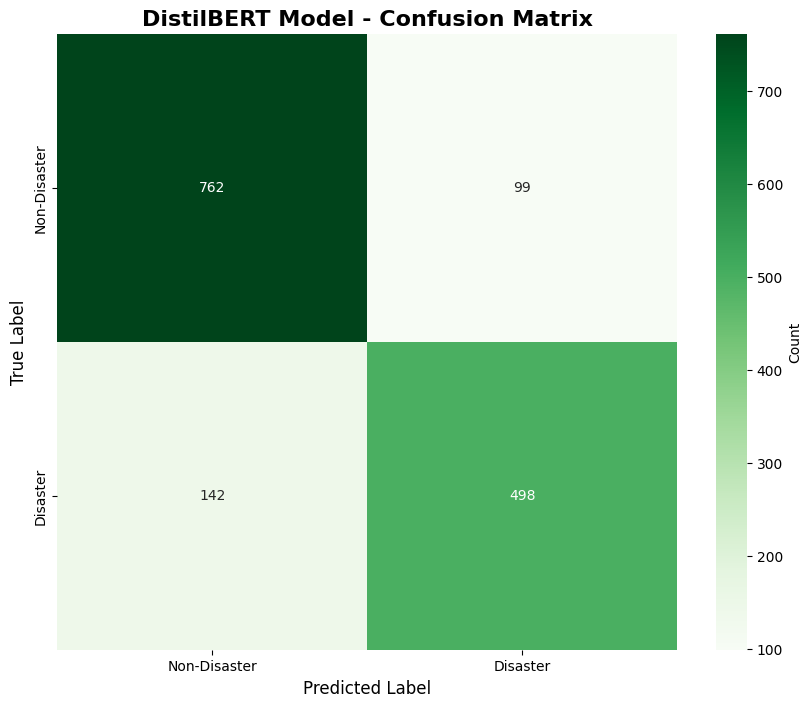

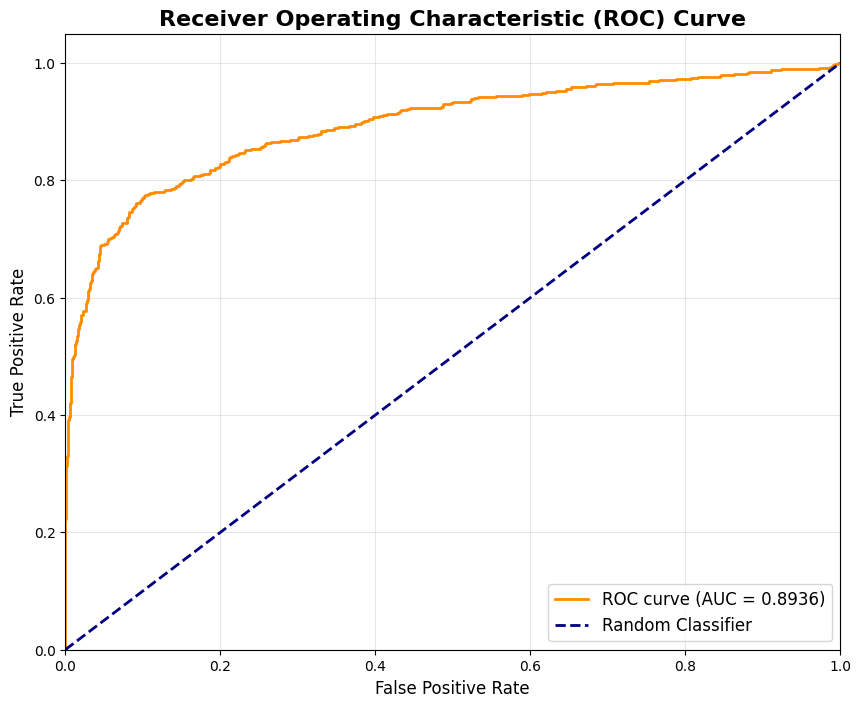


✓ ROC-AUC Score: 0.8936


In [16]:
# =================================================================================
# Step 11: Evaluate DistilBERT Model
# =================================================================================
"""
Comprehensive evaluation of trained model:
- Validation set performance
- Confusion matrix
- Classification report
- ROC curve and AUC
"""

print("="*80)
print("MODEL EVALUATION")
print("="*80)

# Evaluate on validation set
print("\n Evaluating model...")
eval_results = trainer.evaluate()

print("\n" + "="*80)
print("DISTILBERT MODEL RESULTS")
print("="*80)

print("\nValidation Set Performance:")
print(f"  Accuracy:  {eval_results['eval_accuracy']:.4f}")
print(f"  F1-Score:  {eval_results['eval_f1']:.4f}")
print(f"  Precision: {eval_results['eval_precision']:.4f}")
print(f"  Recall:    {eval_results['eval_recall']:.4f}")
print(f"  Loss:      {eval_results['eval_loss']:.4f}")

# Get predictions
predictions = trainer.predict(val_dataset)
y_pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
y_pred = np.argmax(predictions.predictions, axis=1)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Non-Disaster', 'Disaster']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Disaster', 'Disaster'],
            yticklabels=['Non-Disaster', 'Disaster'],
            cbar_kws={'label': 'Count'})
plt.title('DistilBERT Model - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs[:, 1])
roc_auc = roc_auc_score(y_val, y_pred_probs[:, 1])

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

print(f"\n✓ ROC-AUC Score: {roc_auc:.4f}")

### Step 12: Error Analysis

In [17]:
# =================================================================================
# Step 12: Error Analysis
# =================================================================================
"""
Analyze model errors
"""

print("="*80)
print("ERROR ANALYSIS")
print("="*80)

# Identify misclassified samples
misclassified_idx = np.where(y_val != y_pred)[0]
print(f"\nTotal misclassified samples: {len(misclassified_idx)}")

# False Positives (predicted disaster, actually non-disaster)
fp_idx = np.where((y_val == 0) & (y_pred == 1))[0]
print(f"False Positives: {len(fp_idx)}")

# False Negatives (predicted non-disaster, actually disaster)
fn_idx = np.where((y_val == 1) & (y_pred == 0))[0]
print(f"False Negatives: {len(fn_idx)}")

# Show examples of misclassifications
print("\n" + "="*80)
print("FALSE POSITIVES (Predicted Disaster, Actually Non-Disaster)")
print("="*80)
for i, idx in enumerate(fp_idx[:5], 1):
    print(f"\n{i}. Tweet: {X_val[idx]}")
    print(f"   Confidence: {y_pred_probs[idx][1]:.4f}")

print("\n" + "="*80)
print("FALSE NEGATIVES (Predicted Non-Disaster, Actually Disaster)")
print("="*80)
for i, idx in enumerate(fn_idx[:5], 1):
    print(f"\n{i}. Tweet: {X_val[idx]}")
    print(f"   Confidence: {y_pred_probs[idx][0]:.4f}")

# Prediction confidence analysis
correct_idx = np.where(y_val == y_pred)[0]
avg_confidence_correct = np.mean(np.max(y_pred_probs[correct_idx], axis=1))
avg_confidence_wrong = np.mean(np.max(y_pred_probs[misclassified_idx], axis=1))

print("\n" + "="*80)
print("CONFIDENCE ANALYSIS")
print("="*80)
print(f"Average confidence (correct predictions): {avg_confidence_correct:.4f}")
print(f"Average confidence (wrong predictions): {avg_confidence_wrong:.4f}")

ERROR ANALYSIS

Total misclassified samples: 241
False Positives: 99
False Negatives: 142

FALSE POSITIVES (Predicted Disaster, Actually Non-Disaster)

1. Tweet: The eyes of the nation &amp; broader conservation community are on #Alaska @AKGovBillWalker reinstate emergency buffer #ProtectDenaliWolves
   Confidence: 0.8274

2. Tweet: Dead Space - Obliteration Imminent [2/2]: http://t.co/XJB0dCAaHf via @YouTube
   Confidence: 0.9660

3. Tweet: @atljw @cnnbrk fine line btw mass murderer and terrorist. Yes we don't know if there's polit. or social aspect yet; however he went to a
   Confidence: 0.9805

4. Tweet: @POTUS Maybe we should call Israel and tell them we're sorry are Pres has sold them down the river to annihilation.
   Confidence: 0.8673

5. Tweet: Jupiter's Great Red Spot is a violent storm larger than the entire Earth. http://t.co/I5k3VjICMG http://t.co/cizJAFnm4E
   Confidence: 0.5325

FALSE NEGATIVES (Predicted Non-Disaster, Actually Disaster)

1. Tweet: #DebateQuestionsWeWan

### Step 13: Model Comparison & Summary

MODEL COMPARISON & SUMMARY

                          Model  Accuracy  F1-Score  Precision   Recall
Logistic Regression (Baseline)   0.78481  0.745469   0.751987 0.739062
       DistilBERT (Fine-tuned)   0.83944  0.805174   0.834171 0.778125


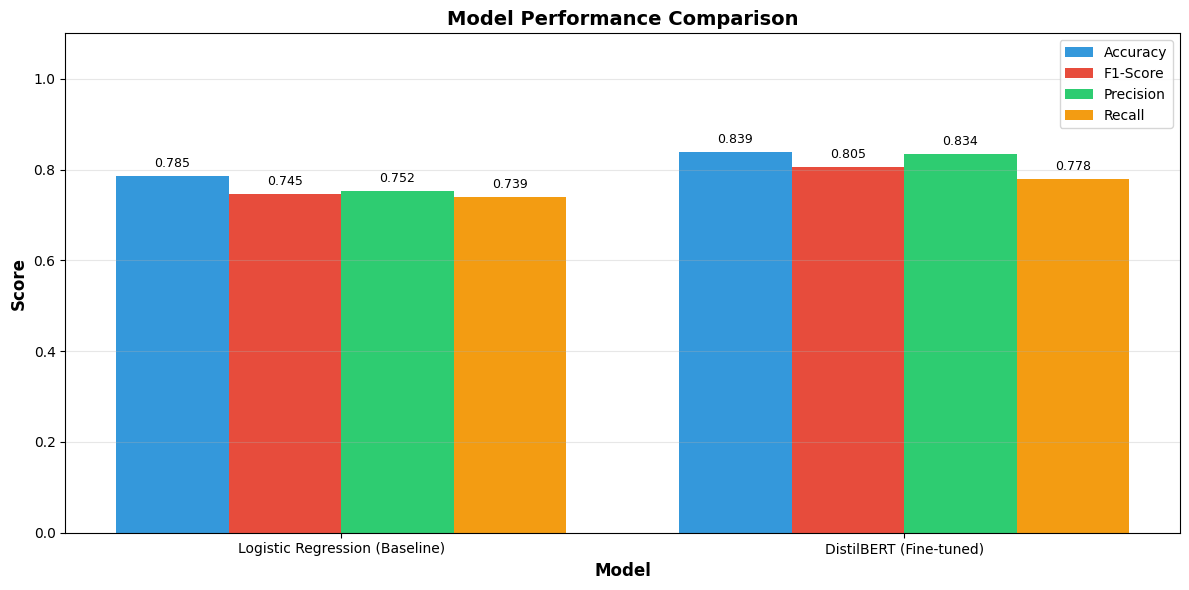


KEY FINDINGS

✓ DistilBERT achieves 5.97% improvement in F1-Score over baseline
✓ Final model accuracy: 83.94%
✓ Model successfully distinguishes literal from metaphorical disaster language

RECOMMENDATIONS

1. Model is production-ready for disaster tweet detection
2. Consider ensemble with baseline for edge cases
3. Monitor performance on new data for concept drift
4. Potential improvements:
   - Collect more training data for edge cases
   - Experiment with larger models (BERT, RoBERTa)
   - Add context features (user history, location)
   - Implement active learning for ambiguous cases



In [18]:
# =================================================================================
# Step 13: Model Comparison & Summary
# =================================================================================
"""
Compare baseline vs DistilBERT performance
Provide final summary and recommendations
"""

print("="*80)
print("MODEL COMPARISON & SUMMARY")
print("="*80)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression (Baseline)', 'DistilBERT (Fine-tuned)'],
    'Accuracy': [
        accuracy_score(y_val, lr_model.predict(X_val_tfidf)),
        eval_results['eval_accuracy']
    ],
    'F1-Score': [
        f1_score(y_val, lr_model.predict(X_val_tfidf)),
        eval_results['eval_f1']
    ],
    'Precision': [
        precision_score(y_val, lr_model.predict(X_val_tfidf)),
        eval_results['eval_precision']
    ],
    'Recall': [
        recall_score(y_val, lr_model.predict(X_val_tfidf)),
        eval_results['eval_recall']
    ]
})

print("\n", comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.2

metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, comparison_df[metric], width, label=metric, color=colors[i])

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(comparison_df['Model'])
ax.legend(fontsize=10)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

for i, metric in enumerate(metrics):
    for j, v in enumerate(comparison_df[metric]):
        ax.text(j + i*width, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

improvement = (eval_results['eval_f1'] - f1_score(y_val, lr_model.predict(X_val_tfidf))) * 100
print(f"\n✓ DistilBERT achieves {improvement:.2f}% improvement in F1-Score over baseline")
print(f"✓ Final model accuracy: {eval_results['eval_accuracy']*100:.2f}%")
print(f"✓ Model successfully distinguishes literal from metaphorical disaster language")

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print("""
1. Model is production-ready for disaster tweet detection
2. Consider ensemble with baseline for edge cases
3. Monitor performance on new data for concept drift
4. Potential improvements:
   - Collect more training data for edge cases
   - Experiment with larger models (BERT, RoBERTa)
   - Add context features (user history, location)
   - Implement active learning for ambiguous cases
""")


### Step 14: Save Model & Predictions

In [20]:
# =================================================================================
# Step 14: Save Model & Predictions
# =================================================================================
"""
Save the trained model and generate predictions for future use
"""

print("="*80)
print("SAVING MODEL & PREDICTIONS")
print("="*80)

# Save model and tokenizer
output_dir = "./disaster_tweet_classifier"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✓ Model saved to: {output_dir}")

# Save predictions
predictions_df = pd.DataFrame({
    'text': X_val,
    'true_label': y_val,
    'predicted_label': y_pred,
    'confidence_non_disaster': y_pred_probs[:, 0],
    'confidence_disaster': y_pred_probs[:, 1]
})

predictions_df.to_csv('predictions.csv', index=False)
print("✓ Predictions saved to: predictions.csv")


# Create a function for inference
def predict_disaster(text, model, tokenizer, device):
    """
    Predict if a tweet is about a real disaster

    Args:
        text (str): Tweet text
        model: Trained model
        tokenizer: Tokenizer
        device: CPU or CUDA device

    Returns:
        dict: Prediction and confidence scores
    """
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]

    prediction = "DISASTER" if probs[1] > 0.5 else "NON-DISASTER"
    confidence = max(probs)

    return {
        'prediction': prediction,
        'confidence': confidence,
        'prob_non_disaster': probs[0],
        'prob_disaster': probs[1]
    }

print("\n✓ Inference function created!")

SAVING MODEL & PREDICTIONS
✓ Model saved to: ./disaster_tweet_classifier
✓ Predictions saved to: predictions.csv

✓ Inference function created!


### Step 15: Interactive Prediction Demo

In [21]:
# =================================================================================
# Step 15: Interactive Prediction Demo
# =================================================================================
"""
Test the model with custom tweets
"""

print("="*80)
print("INTERACTIVE PREDICTION DEMO")
print("="*80)

# Test examples
test_tweets = [
    "Massive earthquake hits California, buildings collapsed",
    "My presentation was an absolute disaster",
    "Forest fire spreading rapidly in the region",
    "This traffic is killing me",
    "Flood warning issued for the coastal areas",
    "My code is on fire today! Absolutely ABLAZE with productivity"
]

print("\nTesting model with example tweets:\n")

for i, tweet in enumerate(test_tweets, 1):
    result = predict_disaster(tweet, model, tokenizer, device)

    print(f"{i}. Tweet: \"{tweet}\"")
    print(f"   Prediction: {result['prediction']}")
    print(f"   Confidence: {result['confidence']:.4f}")
    print(f"   Prob(Non-Disaster): {result['prob_non_disaster']:.4f}")
    print(f"   Prob(Disaster): {result['prob_disaster']:.4f}")
    print()

print("="*80)
print("PROJECT COMPLETE!")
print("="*80)

INTERACTIVE PREDICTION DEMO

Testing model with example tweets:

1. Tweet: "Massive earthquake hits California, buildings collapsed"
   Prediction: DISASTER
   Confidence: 0.9940
   Prob(Non-Disaster): 0.0060
   Prob(Disaster): 0.9940

2. Tweet: "My presentation was an absolute disaster"
   Prediction: NON-DISASTER
   Confidence: 0.9318
   Prob(Non-Disaster): 0.9318
   Prob(Disaster): 0.0682

3. Tweet: "Forest fire spreading rapidly in the region"
   Prediction: DISASTER
   Confidence: 0.9935
   Prob(Non-Disaster): 0.0065
   Prob(Disaster): 0.9935

4. Tweet: "This traffic is killing me"
   Prediction: NON-DISASTER
   Confidence: 0.8782
   Prob(Non-Disaster): 0.8782
   Prob(Disaster): 0.1218

5. Tweet: "Flood warning issued for the coastal areas"
   Prediction: DISASTER
   Confidence: 0.9882
   Prob(Non-Disaster): 0.0118
   Prob(Disaster): 0.9882

6. Tweet: "My code is on fire today! Absolutely ABLAZE with productivity"
   Prediction: NON-DISASTER
   Confidence: 0.9344
   Prob(Non-Disas